In [ ]:
# ---------------------------------------------------------------------
# 0. Imports (dolfinx 0.9.x)
# ---------------------------------------------------------------------
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import pyvista
import imageio
from dolfinx import mesh, fem, la
import dolfinx.fem.petsc    # assemble / lifting helpers

# ---------------------------------------------------------------------
# 1. Mesh and P1 function space
# ---------------------------------------------------------------------
comm        = MPI.COMM_WORLD
Nx, Ny      = 64, 64
domain      = mesh.create_unit_square(comm, Nx, Ny, mesh.CellType.triangle)
V           = fem.functionspace(domain, ("Lagrange", 1))

# ---------------------------------------------------------------------
# 2. Homogeneous Dirichlet boundary (u = 0 on ∂Ω)
# ---------------------------------------------------------------------
def boundary_indicator(x):
    return np.isclose(x[0], 0) | np.isclose(x[0], 1) \
        |  np.isclose(x[1], 0) | np.isclose(x[1], 1)

fdim            = domain.topology.dim - 1
facets          = mesh.locate_entities_boundary(domain, fdim, boundary_indicator)
dofs            = fem.locate_dofs_topological(V, fdim, facets)
zero            = fem.Constant(domain, PETSc.ScalarType(0))
bc              = fem.dirichletbc(zero, dofs, V)      # 👉 wrapper‑safe BC

# ---------------------------------------------------------------------
# 3. Initial condition  u⁰(x,y) = exp(-100·|(x,y)-(0.5,0.5)|²)
# ---------------------------------------------------------------------
u_prev = fem.Function(V, name="u_prev")
dof_xy = V.tabulate_dof_coordinates()        # (ndofs, 2)
r2     = (dof_xy[:, 0] - 0.5)**2 + (dof_xy[:, 1] - 0.5)**2
u_prev.x.array[:] = np.exp(-100.0 * r2)
u_prev.x.scatter_forward()

# ---------------------------------------------------------------------
# 4. Weak forms for implicit Euler
#     (u, v) + Δt (∇u, ∇v)  =  (u_prev, v)     ( RHS has f = 0 )
# ---------------------------------------------------------------------
u      = ufl.TrialFunction(V)
v      = ufl.TestFunction(V)
dt     = 5e-4

a = (u * v + dt * ufl.dot(ufl.grad(u), ufl.grad(v))) * ufl.dx
L = (u_prev * v) * ufl.dx

a_form = fem.form(a)
L_form = fem.form(L)

# ---------------------------------------------------------------------
# 5. Assemble once (matrix & RHS container) – uses la.* API
# ---------------------------------------------------------------------
A_mat  = dolfinx.fem.petsc.assemble_matrix((a_form), bcs=[bc])   # la.MatrixCSR
A_mat.assemble()
b_vec  = dolfinx.fem.petsc.assemble_vector((L_form))               # la.Vector
# NOTE: no explicit .assemble() is needed – la.assemble_matrix already
# fills & finalizes the PETSc matrix internally.

# ---------------------------------------------------------------------
# 6. PETSc linear solver (CG + SOR) – takes la.MatrixCSR directly
# ---------------------------------------------------------------------
ksp = PETSc.KSP().create(comm)
ksp.setOperators(A_mat)                         # accepted in 0.9
ksp.setType(PETSc.KSP.Type.CG)
ksp.getPC().setType(PETSc.PC.Type.SOR)


# ---------------------------------------------------------------------
# 7. Time stepping
# ---------------------------------------------------------------------
u_curr   = fem.Function(V, name="u_curr")
t_finu_curr   = fem.Function(V, name="u_curr")
t_final  = 0.1
n_steps  = int(t_final / dt)

answers : list[dolfinx.fem.function.Function] = []
pngs = [] 
for step in range(1, n_steps + 1):
    # Assemble RHS (b_vec) for the current step
    with b_vec.localForm() as loc:
        loc.set(0.0)

    dolfinx.fem.petsc.assemble_vector(b_vec, L_form)
    dolfinx.fem.petsc.apply_lifting(b_vec, [a_form], bcs=[[bc]])            # account for BCs
    b_vec.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                      mode =PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b_vec, [bc])                                   # enforce BCs in RHS

    # Solve  A u_curr = b
    ksp.solve(b_vec, u_curr.x.petsc_vec)                   # all PETSc objects
    u_curr.x.scatter_forward()

    # Prepare for next step
    u_prev.x.array[:] = u_curr.x.array
     
    
    if step % 2 == 0:
        # build a PyVista mesh & warp it by the solution
        topo, cells, xyz = dolfinx.plot.vtk_mesh(u_curr.function_space)
        grid = pyvista.UnstructuredGrid(topo, cells, xyz)
        grid.point_data["u"] = u_curr.x.array
        grid.set_active_scalars("u")

        # off―screen rendering
        pl = pyvista.Plotter(off_screen=True, window_size=(400,400))
        pl.add_mesh(grid, show_edges=True, clim = [0, 0.5])
        pl.view_xy()
        img = pl.screenshot()
        pngs.append(img)
        pl.close()

    

    if comm.rank == 0 and step % 10 == 0:
        print(f"step {step:3d}/{n_steps},   t = {step*dt:6.4f}")

# ----------------------------------------------------a-----------------
# 8. Write final solution (optional)
# ---------------------------------------------------------------------

print(len(pngs))

if comm.rank == 0:
    with imageio.get_writer("animation.gif", mode = "I", fps=10) as writer:
        for fn in pngs:
            writer.append_data(fn)
    print("Wrote animation.gif")


step  10/200,   t = 0.0050
step  20/200,   t = 0.0100
step  30/200,   t = 0.0150
step  40/200,   t = 0.0200
step  50/200,   t = 0.0250
step  60/200,   t = 0.0300
step  70/200,   t = 0.0350
step  80/200,   t = 0.0400
step  90/200,   t = 0.0450
step 100/200,   t = 0.0500
step 110/200,   t = 0.0550
step 120/200,   t = 0.0600
step 130/200,   t = 0.0650
step 140/200,   t = 0.0700
step 150/200,   t = 0.0750
step 160/200,   t = 0.0800
step 170/200,   t = 0.0850
step 180/200,   t = 0.0900
step 190/200,   t = 0.0950
step 200/200,   t = 0.1000
100
Wrote animation.gif


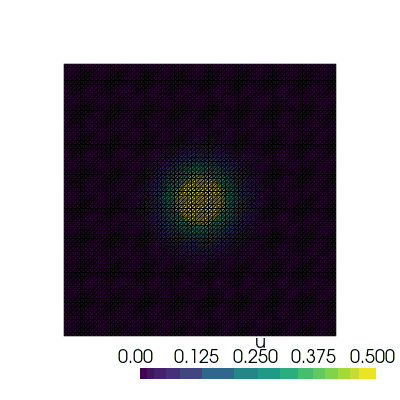

In [1]:
from IPython.display import Image, display
display(Image(filename="animation.gif"))

